# Disaster Tweets Dataset


Link to Kaggle competition: [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started)

Each sample in the train and test set has the following information:
- The `text` of a tweet

- A `keyword` from that tweet (although this may be blank!)

- The `location` the tweet was sent from (may also be blank)

**Goal**: Predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

**Data (columns)**:
- `id` - a unique identifier for each tweet

- `text` - the text of the tweet

- `location` - the location the tweet was sent from (may be blank)

- `keyword` - a particular keyword from the tweet (may be blank)

- `target` - denotes whether a tweet is about a real disaster (1) or not (0)

## Examples

Examples of some tweets with target value equal to 0:
- `I bought a 64oz jar of peanut butter and it's just getting demolished`

- `tomorrow will be the death of me`

- `@fotofill It looks so desolate. End of the world stuff. Gorgeous.`

Examples of some tweets with target value equal to 1:
- `#Afghanistan: sharp rise in women and children casualties in first half of #2015 http://t.co/LdyWd4ydT9`

- `Storm damage reported in West Tennessee http://t.co/90L2lB5WMr`
- `Adult dies of plague in Colorado http://t.co/yoHVuwuMZS`

Next tweet is interesting because it is labelled as a disaster, but
it's quote from game and location value is `Whiterun, Skyrim`
which is a location of a town in game `Skyrim`. We can conclude
that quality of this dataset is not ideal.
- `Destruction magic's fine just don't go burning down any buildings`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
import os

In [2]:
df = pd.read_csv('../data/tweet_disaster.csv')
print('Dataset size:', df.shape[0])
df.head()

Dataset size: 7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Column `id` can be dropped.

In [3]:
df = df.drop('id', axis=1)
df.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Target

In [4]:
# There is not missing tweet label
df.target.isna().any()

False

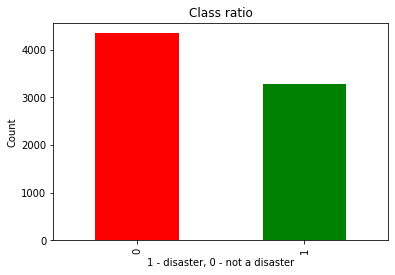

In [5]:
# Dataset has more 0 instances but they are fairly balanced
df.target.value_counts().plot.bar(color=['red', 'green'])
plt.xlabel('1 - disaster, 0 - not a disaster')
plt.ylabel('Count')
plt.title('Class ratio')
plt.show()

## Feature "keyword"

In [6]:
def clean_feature_keyword(df: pd.DataFrame) -> pd.DataFrame:
    # Blank line (nan) means there is not keyword
    df.keyword = df.keyword.fillna('none')
    # Rreplacing space character with '_'
    df.keyword = df.keyword.astype('str').apply(lambda x: x.replace('%20', '_'))
    return df

df = clean_feature_keyword(df)
df.keyword.describe()

count     7613
unique     222
top       none
freq        61
Name: keyword, dtype: object

In [7]:
def show_examples(series: pd.Series, n: int = 10) -> None:
    sample = series.unique()
    random.shuffle(sample)
    for s in sample[:n]:
        print(f'"{s}"')

print('Keyword examples:')
show_examples(df.keyword)

Keyword examples:
"sinking"
"storm"
"suicide_bombing"
"death"
"tornado"
"whirlwind"
"dust_storm"
"crashed"
"cyclone"
"collision"


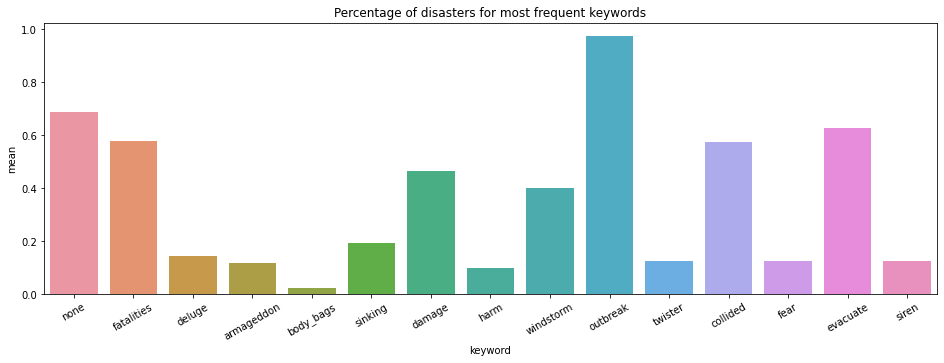

In [8]:
top10 = (df.groupby('keyword')['target']
    .agg(['count', 'mean'])
    .reset_index()
    .sort_values(by='count', ascending=False)
    .head(15))

# Analysis of 10 most frequent words
fig, ax = plt.subplots(figsize=(16, 5))
plt.title('Percentage of disasters for most frequent keywords')
sns.barplot(x='keyword', y='mean', data=top10, ax=ax)
plt.xticks(rotation=30)
plt.show()

## Feature "location"

In [9]:
def clean_feature_location(df: pd.DataFrame) -> pd.DataFrame:
    # Blank line (nan) means that location is unknown
    df.location = df.location.fillna('none')
    return df

df = clean_feature_location(df)
df.location.describe()

count     7613
unique    3342
top       none
freq      2533
Name: location, dtype: object

In [10]:
print('Location examples:')
show_examples(df.location)

Location examples:
"i beg vines sorry "
"A.A.S my Aztec Princess"
"University of Limerick"
"EARTH"
"Federal Capital Territory"
"Fountain Valley, CA"
"Tn"
"Njoro, Kenya"
"Alicante, Valencia"
"Somewhere Only We Know ?"


Feature `location` has bad quality and won't be analysed further because it requires lot of time which may not be worth it.

## Feature "text"

Full exploratory analysis for this feature would be very long since all kind of interesting facts can be learning from tweets. Feature "text" will be cleaned with function `process_text` which contains these steps:
1. `filter_printable`, there are 'unprintable' characters from foreign languages;

2. `remove_links`;

3. `remove_punctuations`;

4. `to_lowercase`;

5. `remove_nonwords`, non-english are removed;

6. `lemmatize`, examples: 'reasons' -> 'reason', 'playing' -> 'play', ...;

7. `remove_stop_words`, examples: don't, some, such, ....

For each of these steps there could be have made analysis and feature extraction. Example:
- Does it matter if tweet is on foreign language?
- Does it matter if tweet has links? Advertisement tweets usually have links.
- Are tweets with higher count of '!' more likely to be disaster tweets?
- Are disaster tweets shorter?
- ...

This is postponed for later work.

In [11]:
from transform import process_text
df = process_text(df)
df.head()

,keyword,location,text,target
0,none,none,reason earthquake may forgive u,1
1,none,none,forest fire near la canada,1
2,none,none,shelter place notify evacuation shelter place,1
3,none,none,people receive evacuation,1
4,none,none,get send photo ruby smoke school,1


In [12]:
unique_words = set()
df.text.str.lower().str.split().apply(unique_words.update)
print('Number of unique words:', len(unique_words))

Number of unique words: 5557


### Visualization using WordCloud

[Wordcloud](https://en.wikipedia.org/wiki/Tag_cloud) is a way of visualizing the frequency distribution of words in text. 

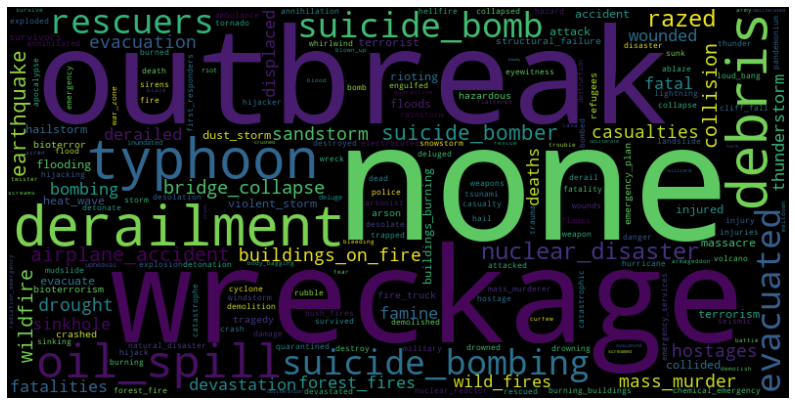

In [13]:
def plot_word_cloud(data, target):
    text = dict(data[data.target==target].keyword.value_counts())
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(text)
    plt.figure(figsize=[14,8])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    
plot_word_cloud(df, 1)    
plt.show()

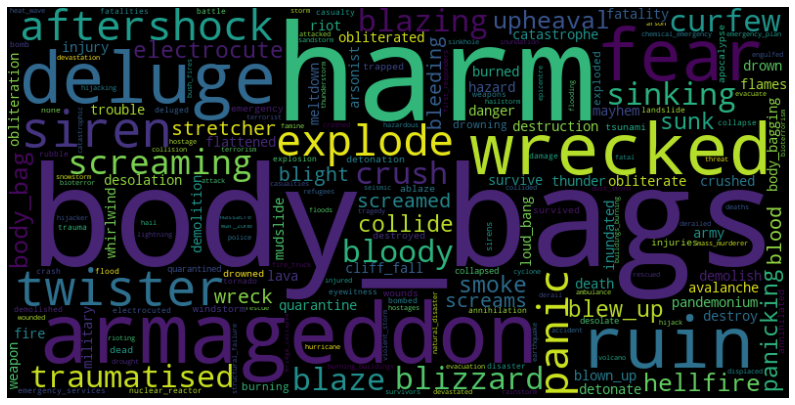

In [14]:
plot_word_cloud(df, 0)    
plt.show()

### Visualization using PCA/T-SNE

In [15]:
from vocabulary import Vocabulary
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Vocabulary is custom class that transforms words to vectors using glove.6B.100d
vocabulary = Vocabulary()

# Filtering words that are not in vocabulary
df.text = df.text.apply(vocabulary.remove_unknown)
df = df[df.text.str.strip() != '']
df = df.reset_index(drop=True)

disaster_tweets_indices = df[df.target==1].index.values
non_disaster_tweets_indices = df[df.target==0].index.values

X_glove_max = np.stack([vocabulary.maximum(sentence) for sentence in df.text])
X_glove_avg = np.stack([vocabulary.average(sentence) for sentence in df.text])
X_tdidf = TfidfVectorizer().fit_transform(df.text).toarray()
X_count = CountVectorizer().fit_transform(df.text).toarray()

representations = [
    ('Glove - Max', X_glove_max),
    ('Glove - Avg', X_glove_avg),
    ('TfIdf', X_tdidf),
    ('Count', X_count)
]

In [16]:
def plot_projection(X, disaster_tweets_indices, non_disaster_tweets_indices, projection, ax, title, 
                    *args, **kwargs):
    Xp = projection.fit_transform(X)
    ax.scatter(Xp[disaster_tweets_indices][:, 0], Xp[disaster_tweets_indices][:, 1], 
                color='red', label='disaster', *args, **kwargs)
    ax.scatter(Xp[non_disaster_tweets_indices][:, 0], Xp[non_disaster_tweets_indices][:, 1], 
                color='green', label='non-disaster', *args, **kwargs)
    ax.set_title(title)
    ax.legend()

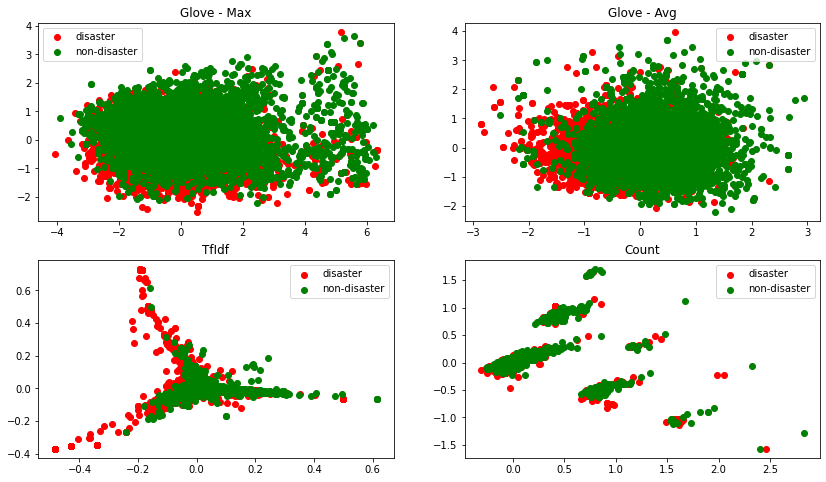

In [17]:
def plot_projected_representations(representations, projection):
    fig, axs = plt.subplots(figsize=(14, 8), nrows=2, ncols=2)
    for plot_index, (r_name, X) in enumerate(representations):
        i = plot_index // 2
        j = plot_index % 2

        plot_projection(X, disaster_tweets_indices, non_disaster_tweets_indices, 
                        projection=projection, ax=axs[i][j], title=r_name)
        
plot_projected_representations(representations, projection=PCA(n_components=2))
plt.show()

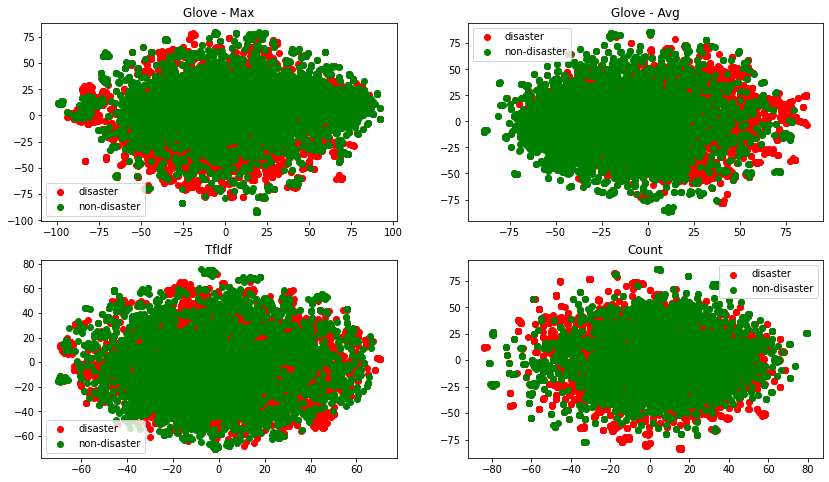

In [18]:
plot_projected_representations(representations, projection=TSNE(n_components=2, random_state=42))
plt.show()